In [5]:
import json
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
from glob import glob

from preprocess import Preprocess

In [6]:
pd.__version__, np.__version__

('1.4.1', '1.22.3')

In [7]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None, style_ths=0.1):

        self.style_ths_str = str(style_ths)[-1]
#         self.compare_y = False
        self.df = df
        self.qval = qval  # Q-Value : 거리 유사도 알고리즘에서 q-gram 으로 문장을 어떻게 나눌지 결정하는 파라미터 (None:단어기반, 1:철자기반, 2~more:q-gram)
        self.df_ = self.preprocess_df(self.df)  # new_tag feature를 새롭게 추가 전처리
        self.user_item_set = set()  # 사용자가 아이템을 선택(검색/추천)시 => 사용자가 선택한 아이템 목록
        self.cold_start = True   # Cold Start : 최적화된 추천 알고리즘 선택을 위해 사용자의 아이템 목록이 비어있는지 확인하는 변수
        
    def preprocess_df(self, df):
        # make new-tag
        # top3_style, tags, name, projectId 를 하나의 string으로 만들기
        df['new_tag'] = list(
                            zip(
                                df[f'top_style_{self.style_ths_str}'].tolist(), 
                                df['tags'].tolist(),
                                df['name'].tolist(),
                                df['projectId'].tolist()
                                )
                            )
        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag
    
    # 사용자 셋에 아이템 추가
    def add_item_in_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에 [{prod}]를 추가합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
    ##
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.add((id_, cat_))
    ##
        self.cold_start = False
        print(f'사용자 님이 현재 선택한 아이템 목록 : {self.user_item_set}')
        return id_
    
    # 사용자 셋에서 아이템 제거
    def remove_item_from_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에서 [{prod}]를 제거합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
    ##
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.remove((id_, cat_))
    ##
        print(f'사용자 님의 현재 남아있는 선택된 아이템 목록 : {self.user_item_set}')
        # 사용자 목록이 비게 되면 콜드스타트
        if len(self.user_item_set) > 1:
            self.cold_start = True
    
    # 사용자가 선택한 아이템과 데이터 내 모든 아이템들과의 유사도 계산
    def get_similarity_score(self, search_prod_tag, algo='sorensen'):
        """
        search_prod_tag : string, 사용자가 선택한 아이템 이름으로부터 매칭된 self.df_['new_tag'].values
        """
        # calculate similarity
        sim_score = []
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
        print(f'검색 태그 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')
        print()
        return sim_score
    
    # 사용자 선택한 아이템/아이템 목록으로부터 유사도를 통해 아이템 추천
    def search_product(self, prod, topn=10, algo='sorensen'):
        """
        prod : string, 아이템 이름
        topn : int, 유사도 상위 n개의 아이템 추천
        algo : 'sorensen' - 토큰 기반 거리 유사도 알고리즘, 'ncd' - 문장 압축을 통한 유사도 알고리즘
        """
        # 아이템을 사용자 아이템 목록에 추가
        # declare id, category of searching product
        id_ = self.add_item_in_user_item_set(prod)
        prod_cat = self.df_[self.df_['product_id'] == id_]['category'].values[0]
        # if prod_cat == np.nan:
        #     prod_cat = self.df_[self.df_['product_id'] == id_]['category_b'].values[0]
        #     self.compare_y = True
        
        print(f"검색 아이템이 해당한 프로젝트 ID : {self.df_[self.df_['name'] == prod]['projectId'].values[0]}")
        
        if self.cold_start:
            # retrieve the product tag from the input product id
            # 동일 아이템이 여러 전문가에 사용될 경우 => awesome_score 가 더 높은 점수를 받은 아이템의 new_tag를 가져옴
            search_prod_tag = self.df_[self.df_['product_id'] == id_].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
        else:
            search_prod_tag = ''
            for existing_item_id, _ in self.user_item_set:
                temp_id = self.df_[self.df_['product_id'] == existing_item_id].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
                search_prod_tag += temp_id+' '
            search_prod_tag = search_prod_tag[:-1]
            
        # 해당 아이템-다른 아이템 간 유사도 계산
        sim_score = self.get_similarity_score(search_prod_tag, algo=algo)
        
        # save result
        sim_score = np.asarray(sim_score)  # [사용자가 선택한 아이템-다른 모든 아이템] 간 유사도 점수
        sim_score_idx = np.arange(len(sim_score)) # 유사도 점수에 대한 인덱스
        
        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 
                                                  'new_tag', 'projectId', 
                                                  'images', 'category']]
        result_df['similarity'] = sim_score
        
        # filtering
        result_df = result_df[result_df['product_id']!=id_]  # 사용자가 선택한 아이템과 동일한 아이템 제거
        result_df = result_df.drop_duplicates(['product_id'])  # 중복된 아이템 제거
        
    ## [2022-03-12 : 이루오] - 추가된 코드 시작
        # 사용자가 이미 선택한 아이템들은 추천목록에서 제거
        if len(self.user_item_set) > 1:
            print("!!사용자가 이미 선택한 아이템, 같은 카테고리 아이템들은 추천목록에서 제거!!")
            for existing_item_id, existing_item_cat in self.user_item_set:
                result_df = result_df[result_df['product_id']!=existing_item_id]
                result_df = result_df[result_df['category']!=existing_item_cat]
                
    ## [2022-03-12 : 이루오] - 추가된 코드 끝
    
        result_df = result_df[result_df['category'] != prod_cat] 
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn] # 유사도가 가장 높은 순서대로 정렬 => top-n개 까지 추천 결과 저장
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 1

        self.result = result_df

In [8]:
# base_path = '2022-03-07/'
# file_paths = [
#     base_path + 'bestshots.json', 
#     base_path + 'items.json', 
#     base_path +'categories.json', 
#     base_path +'products.json'
# ]

In [9]:
base_bath = '2022-03-07/'

# abs path -> 22-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'products*.json')
#category1 == category2 = True
category = glob(base_bath+'categories.json')

In [10]:
best, item, products, category

(['2022-03-07/bestshots.json', '2022-03-07/bestshots_0.json'],
 ['2022-03-07/itemsets.json', '2022-03-07/items.json'],
 ['2022-03-07/products_meta.json', '2022-03-07/products.json'],
 ['2022-03-07/categories.json'])

In [11]:
# 데이터전처리 클래스로부터 객체 선언하기
# style_ths = 0.1
# style_ths_str = str(style_ths)[-1]
st = time.time()
DATA = Preprocess(best, item, products, category)
print(f"{time.time()-st}초")

/Users/ruo/Desktop/codestates/CP2/preprocess.py:92: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack.reset_index(),


2.0075159072875977초


In [12]:
best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b
best_item_df.shape, products_df_4.shape, products_df_b.shape

((4556, 38), (4244, 12), (45841, 12))

In [14]:
samp_project_list = best_item_df[best_item_df['projectId'].apply(lambda x: x.lower()) == 'x4lqunbc1d9159747a64c5e']['items'].values.tolist()

In [15]:
for item_name in products_df_b.name.tolist():
    if 'chair' in item_name:
        print(item_name)
        break

In [16]:
for item_id in samp_project_list[0]:
    print(products_df_b[products_df_b['product_id'] == item_id]['name'].values[0])

스위치
메리미 이중레이스 암막커튼 530사이즈 3colors ( 크림베이지 )
사티 3인용 소파 드리밍헤비 가죽 (펄아코야)
스페인 노블리사 모던 거실 카페트 모음 레온그레이 (200X250)
사각형 천장등
퓨어 미니 LED 벽시계 화이트골드
카스카 콘솔테이블 800 (블랙)
AI ThinQ 스마트 나노셀 TV 86NANO93KNB 86인치 벽걸이형 (블랙)
스파트필름(중형) - 해초 라탄바구니 세트
Archisketch Wall Deco Plant
모다 애쉬원목 통세라믹 6인 식탁세트(벤치1+의자3) (라이트그레이+파스텔블루+다크그레이)
콤펙타 조화나무 (내추럴)
Archisketch Etc Plants (White)
WINDY FOREST FABRIC POSTER(윈디 포레스트 패브릭포스터)
Archisketch Deco Rose
튤립 조화(10P) 화병 세트 레드
코코넛 마크라메 행잉플랜트 (아이비)


In [19]:
search_engine_b.df_

,projectId,top_style_1,awesome_score,product_id,use_count,name,tags,dimensions,images,item_name,enterpriseId,category,new_tag
0,X9djPepD57A2BDCD418437C,NATURAL,0.993074,XjDwfV4C2377DB2C32B4EBD,10,onion 진저 주방 수납장 (내추럴),"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...","{'width': 800, 'height': 870, 'depth': 400, 'u...",[https://resources.archisketch.com/product/XjD...,onion 진저 주방 수납장 (내추럴),B57D4F97C0E44A11,수납가구,natural 렌지대 주방수납 주방장 주방선반 베이지 가공목(mdf외) 가공목 나무...
1,X9dU4bb1CF0EE26E341493B,NATURAL,0.983243,XjDwfV4C2377DB2C32B4EBD,10,onion 진저 주방 수납장 (내추럴),"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...","{'width': 800, 'height': 870, 'depth': 400, 'u...",[https://resources.archisketch.com/product/XjD...,onion 진저 주방 수납장 (내추럴),B57D4F97C0E44A11,수납가구,natural 렌지대 주방수납 주방장 주방선반 베이지 가공목(mdf외) 가공목 나무...
2,X9a1taeFAA511E93B794404,NATURAL,0.893659,XjDwfV4C2377DB2C32B4EBD,10,onion 진저 주방 수납장 (내추럴),"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...","{'width': 800, 'height': 870, 'depth': 400, 'u...",[https://resources.archisketch.com/product/XjD...,onion 진저 주방 수납장 (내추럴),B57D4F97C0E44A11,수납가구,natural 렌지대 주방수납 주방장 주방선반 베이지 가공목(mdf외) 가공목 나무...
3,X8Ao1yi02242EB57CD44E0B,MODERN NATURAL,0.839363,XjDwfV4C2377DB2C32B4EBD,10,onion 진저 주방 수납장 (내추럴),"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...","{'width': 800, 'height': 870, 'depth': 400, 'u...",[https://resources.archisketch.com/product/XjD...,onion 진저 주방 수납장 (내추럴),B57D4F97C0E44A11,수납가구,modern natural 렌지대 주방수납 주방장 주방선반 베이지 가공목(mdf외)...
4,X8MtJveB527ACDC1FE44F66,NATURAL MODERN,0.981309,XjDwfV4C2377DB2C32B4EBD,10,onion 진저 주방 수납장 (내추럴),"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...","{'width': 800, 'height': 870, 'depth': 400, 'u...",[https://resources.archisketch.com/product/XjD...,onion 진저 주방 수납장 (내추럴),B57D4F97C0E44A11,수납가구,natural modern 렌지대 주방수납 주방장 주방선반 베이지 가공목(mdf외)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45836,X1_RuIOE8ACEF7EC03246FB,MODERN,0.859769,XVUcpfK862F9434D3B8413E,1,MKB 캐비넷 6문 수납장 6colors 9131600 라이트그레이,"[수납장, 수납, 캐비넷, 캐비닛, 케비넷, 케비닛, 그레이, 회색, 철재/스틸, ...","{'width': 913, 'height': 1600, 'depth': 455, '...",[https://resources.archisketch.com/product/XVU...,MKB 캐비넷 6문 수납장 6colors 9131600 라이트그레이,B57D4F97C0E44A11,수납가구,modern 수납장 수납 캐비넷 캐비닛 케비넷 케비닛 그레이 회색 철재/스틸 철재 ...
45837,X4Woi5l64D1CDAD81B64B66,MODERN NATURAL MINIMAL,0.848643,XTsmfRBD3B8F6C0BF274BB1,1,미쉘 원목 카페 식탁의자 4colors (내추럴),"[일반의자, 식탁의자, 인테리어의자, 주방의자, 베이지, 원목, 내추럴, 나무, 우...","{'width': 561, 'height': 730, 'depth': 433, 'u...",[https://resources.archisketch.com/product/XTs...,미쉘 원목 카페 식탁의자 4colors (내추럴),B57D4F97C0E44A11,의자/스툴,modern natural minimal 일반의자 식탁의자 인테리어의자 주방의자 베...
45838,X4Woi5l64D1CDAD81B64B66,MODERN NATURAL MINIMAL,0.848643,XkM8XJXFA603CD7FB3747A4,1,Marcus 2인용 다용도 원형테이블 (화이트),"[테이블, 태이블, 탁자, 식탁, 다이닝테이블, 다이닝식탁, 식탁테이블, 화이트, ...","{'width': 900, 'height': 760, 'depth': 900, 'u...",[https://resources.archisketch.com/product/XkM...,Marcus 2인용 다용도 원형테이블 (화이트),B57D4F97C0E44A11,책상/테이블,modern natural minimal 테이블 태이블 탁자 식탁 다이닝테이블 다이...
45839,X4WvMcUD91ACAF3D1654EDF,MODERN NATURAL,0.838062,XfWk4HE96C12C678865467F,1,하제 원목스툴 의자 4colors (블랙),"[스툴, 일반스툴, 블랙, 검정, 검은, 검은색, 원목, 내추럴, 나무, 우드, 네...","{'width': 410, 'height': 450, 'depth': 240, 'u...",[https://resources.archisketch.com/product/XfW...,하제 원목스툴 의자 4colors (블랙),B57D4F97C0E44A11,의자/스툴,modern natural 스툴 일반스툴 블랙 검정 검은 검은색 원목 내추럴 나무 ...


In [17]:
# qval=None => 아이템과 유사한 카테고리의 결과 추천 / qval=int => 아이템과 비슷한 스타일의 다른 아이템 추천(기존 전문가 셋을 기반)
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=None)

사용자 님의 아이템 목록에 [카스카 콘솔테이블 800 (블랙)]를 추가합니다.
사용자 님이 현재 선택한 아이템 목록 : {('XxzI_ZI3577203D31674CBD', '책상/테이블')}
검색 아이템이 해당한 프로젝트 ID : X4lQuNBC1D9159747A64C5E
검색 태그 : natural modern 블루밍홈 카스카 콘솔테이블 800 (블랙) x4lqunbc1d9159747a64c5e
검색 시간 : 0.5175초

사용자가 선택한 아이템 : 카스카 콘솔테이블 800 (블랙)


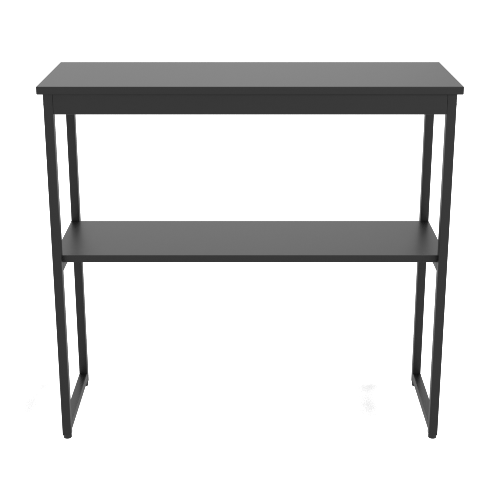

추천 아이템 Top10
추천 1순위 : 파티션 (블랙)


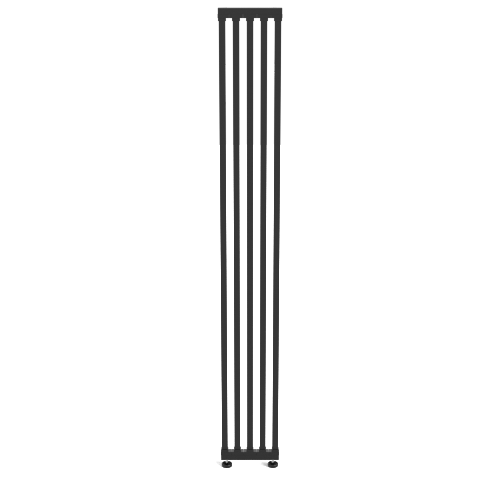

------------------------------------------------------------
추천 2순위 : 모던 상부장 (블랙)


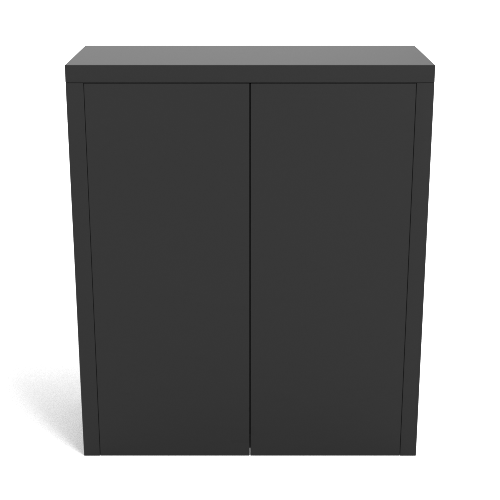

------------------------------------------------------------
추천 3순위 : 키 큰장 (블랙)


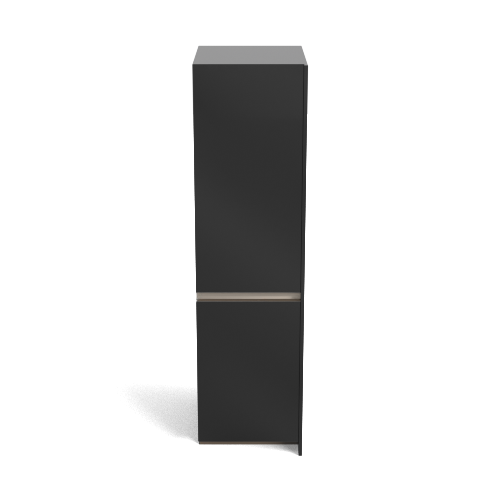

------------------------------------------------------------
추천 4순위 : 누디 LED조명 (블랙) (S)


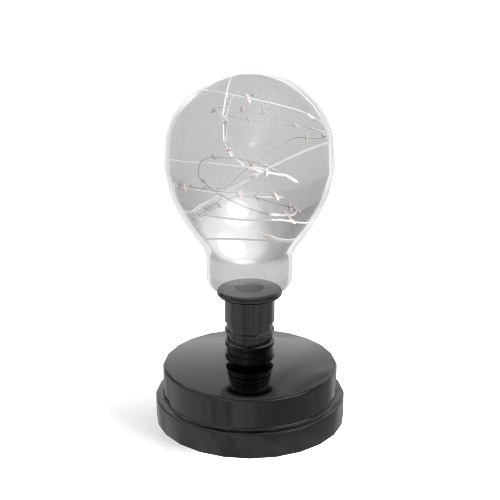

------------------------------------------------------------
추천 5순위 : 모던데일 3단 수납선반 (블랙)


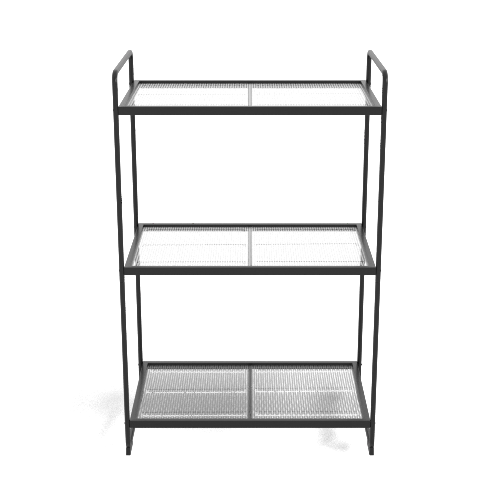

------------------------------------------------------------
추천 6순위 : 레트로 스탠드 (블랙)


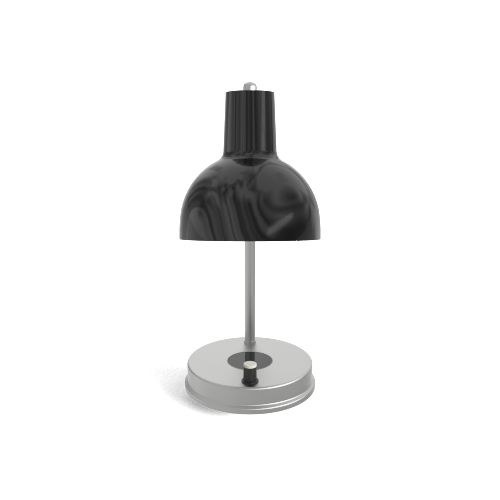

------------------------------------------------------------
추천 7순위 : 마샬 스탠모어2 스탠드 (블랙)


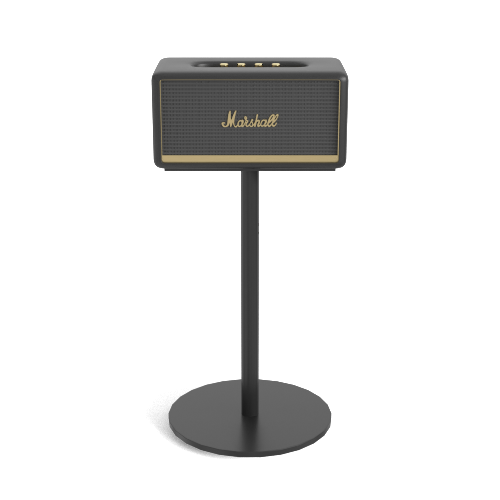

------------------------------------------------------------
추천 8순위 : 틴우드 타공판 철제파티션 800 (하프) (블랙)


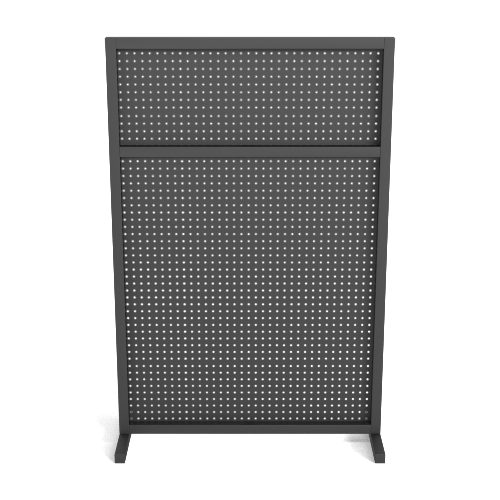

------------------------------------------------------------
추천 9순위 : 쉘체어 골드다리 (블랙)
이미지 없음

------------------------------------------------------------
추천 10순위 : 로이드 이동식 행거 1단 (블랙)


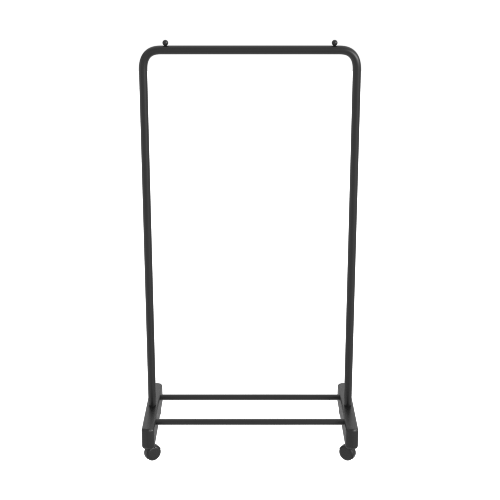

------------------------------------------------------------


In [18]:
prod = "카스카 콘솔테이블 800 (블랙)"
search_engine_b.search_product(prod, topn=10)

In [58]:
search_engine_b.result

,index,product_id,name,new_tag,projectId,images,category,similarity
0,24063,4621743EDE254659,파티션 (블랙),modern natural 파티션 (블랙) x8gwukf0036c3f8ee4f4e43,X8gwUKf0036C3F8EE4F4E43,[https://resources.archisketch.com/product/462...,파티션/구조물,0.285714
1,45766,XkM-52P4858A00F8CFB4FB8,키 큰장 (블랙),modern natural 키 큰장 (블랙) x4rwiln6a20b3b4241c4085,X4RwILN6A20B3B4241C4085,[https://resources.archisketch.com/product/XkM...,주방싱크/욕실,0.272727
2,45765,Xb5mXt8F7F118730F694578,모던 상부장 (블랙),modern natural 모던 상부장 (블랙) x4rwiln6a20b3b4241c...,X4RwILN6A20B3B4241C4085,[https://resources.archisketch.com/product/Xb5...,주방싱크/욕실,0.272727
3,37039,XxzI_YtDA93412DC82E4770,모던데일 3단 수납선반 (블랙),modern natural 네이쳐리빙 모던데일 3단 수납선반 (블랙) x8qvkh9...,X8qvKH99D66947E43E448FA,[https://resources.archisketch.com/product/Xxz...,책장/선반,0.250000
4,41980,XxzI_YV2F4D21A969B04B4F,쉘체어 골드다리 (블랙),modern natural minimal 체어팩토리 쉘체어 골드다리 (블랙) x7p...,X7pEbTE9C6C60BA2520413E,[],의자/스툴,0.250000
5,43400,XxzIVRnC1FE959D3DB94577,누디 LED조명 (블랙) (S),natural modern 룸앤홈 누디 led조명 (블랙) (s) x6u4cvoc3...,X6u4CVOC32B4ACA23BD460C,[https://resources.archisketch.com/product/Xxz...,조명,0.250000
6,36510,XZBrDpICCF3514448384506,틴우드 타공판 철제파티션 800 (하프) (블랙),modern 틴우드 타공판 철제파티션 800 (하프) (블랙) x6-rgx8aab3...,X6-rGx8AAB3D64F41494EFB,[https://resources.archisketch.com/product/XZB...,파티션/구조물,0.250000
7,43382,XvJtJXD5C8384C352744AD2,레트로 스탠드 (블랙),natural modern minimal 에이모노 레트로 스탠드 (블랙) xrmiu...,XrMIUdt86DFBE2B4392445E,[https://resources.archisketch.com/product/XvJ...,조명,0.250000
8,43789,Xs_QLW30E80ECA360734CC0,로미 접이의자 (블랙),modern 일반의자 식탁의자 인테리어의자 주방의자 블랙 검정 검은 검은색 인조가죽...,X5B5rS828CD0D9FA4AB41E9,[https://resources.archisketch.com/product/Xs_...,의자/스툴,0.250000
9,7551,Xz-wAFG5D21CEBFC5AD4DDC,마샬 스탠모어2 스탠드 (블랙),modern natural 마블홀릭 마샬 스탠모어2 스탠드 (블랙) xmzhlma2...,XmZHLmA2EFEBAE4248B4BD8,[https://resources.archisketch.com/product/Xz-...,가전,0.250000


In [38]:
DATA.products_4.drop_duplicates('name')['name'].tolist()

['Archisketch Kitchen Sink H W',
 '대리석 싱크대 (일자형)',
 '싱크대 상+하부장 세트 (싱크대) (화이트)',
 '싱크대 상+하부장 세트 (원도어) (화이트)',
 '싱크대 상+하부장 세트 (가스렌지) (화이트)',
 '아키라 55A_on',
 '긴잎아카시아 둥근잎 델바타 화이트볼 세라믹화분',
 'Cornet Bar Stool (Cream White Legs / Oiled Oak Seat)',
 'TRADITION Table 1400',
 '슬림 양념 정리대',
 '안개꽃 조화',
 'FINANSIELL 피난시엘 (화이트)',
 '5x7 액자',
 '미니 램프 드 마르세유(화이트)_on',
 '프롭 패브릭 체어 (오크 + 라이트 그레이)',
 '프롭 패브릭 체어 (월넛 + 라이트 그레이)',
 '8x10액자',
 'Bauhaus-Sport(Brown wood)',
 'PASTELS (Light brown wood)',
 'Ideal living - 50s(White wood)',
 'Jakub Zasada - Bon Appetit (Black Aluminum)',
 'FIAC 84 (White Aluminum)',
 'From the Central Palace, 1933 White wood',
 'Hilma Af Klint - The Ten Largest No.2, Childhood(Gold Aluminum)',
 '여기서 이대로 - 김유라 작가(matt black)',
 'JUMP INTO THE FUTURE Black Wood',
 'Hilma Af Klint - The Ten Largest No.1, Childhood(Black wood)',
 'Cactus - 차한별 작가(A2 snow white)',
 'Archisketch Circle Light_on',
 '아이린 자수 호텔 침구 Q (화이트)',
 'Comfy Sofa Stool(오트밀)',
 'Two Legs Side Table (White)',
 '텐셀 와플 

In [4]:
DATA.df_

NameError: name 'DATA' is not defined

In [43]:
DATA.best_json[DATA.best_json['id'] == 'X9FwT9TB461A316FD4A402F']

,awesome_score,date,datetime,enterprise_id,id,projectId,style_predictions,top_score,top_style


In [33]:
pd.read_json(DATA.products[1]).T[pd.read_json(DATA.products[1]).T['_id'] == 'X9enN3iCB5C02807C324267']

,_id,name,modelUrl,enterpriseId,userId,categories,archiCategories,description,tags,brand,...,renderValues,color,renderSettings,renderMaterial,hdViewerImages,ar,option,parentProduct,createdAt,updatedAt


In [38]:
DATA.products_json[DATA.products_json['_id'] == 'X9FwT9TB461A316FD4A402F']

,_id,name,modelUrl,enterpriseId,userId,categories,archiCategories,description,tags,brand,...,color,renderSettings,renderMaterial,hdViewerImages,ar,option,parentProduct,createdAt,updatedAt,category_name


In [12]:
products_df = DATA.products_json

In [13]:
products_df['category_name'] = products_df['categories'].apply(lambda x: pd.Series(x)).reset_index(drop=True).drop(columns=1)

/var/folders/9_/rnj5svk11p1157tkdv28yb6r0000gn/T/ipykernel_61144/3170452617.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  products_df['category_name'] = products_df['categories'].apply(lambda x: pd.Series(x)).reset_index(drop=True).drop(columns=1)


In [14]:
products_df.head(1).T

,0
_id,X5rPclT9CFB7E73DEA8495A
name,4F_TV
modelUrl,None
enterpriseId,15BEED4FED5A48FD
userId,36F2E1069E1140E6
categories,[X5sOfKR8EE6E3FB89134354]
archiCategories,[]
description,None
tags,[]
brand,None


In [22]:
DATA.products_json[DATA.products_json['_id']=='X5w9JQZ1E88574BAB554CFD']

,_id,name,modelUrl,enterpriseId,userId,categories,archiCategories,description,tags,brand,...,color,renderSettings,renderMaterial,hdViewerImages,ar,option,parentProduct,createdAt,updatedAt,category_name
149,X5w9JQZ1E88574BAB554CFD,파츠1 체어,None,421B6D0E746C4E6D,X5l3CBbCD3E0524519C4215,[],None,None,[오블리크테이블],오블리크 테이블,...,"{'code': 'none', 'name': '그레이'}",{'tempararyConfigure': 'config_X5xmJtV.archisk...,false,[],{'android': 'https://d2uz6y97crd8bk.cloudfront...,None,X62MVyw48AA05CD75B148B2,2022-01-25T04:48:39.637Z,2022-01-25T05:01:47.183Z,NaN


In [16]:
DATA.products_4.head()

,projectId,top_style_1,awesome_score,product_id,use_count,name,tags,dimensions,images,item_name,enterpriseId,category,new_tag
0,X9apiW291EB7A3636F64523,MODERN,0.986057,FE1DE8319CFA4CC6,102,Archisketch Kitchen Sink H W,[],"{'width': 500, 'height': 800, 'depth': 320, 'u...",[https://resources.archisketch.com/product/FE1...,Archisketch Kitchen Sink H W,421B6D0E746C4E6D,Kitchen,modern archisketch kitchen sink h w x9apiw291e...
1,X9crFBI1F8DB6AA234545ED,MODERN,0.949370,FE1DE8319CFA4CC6,102,Archisketch Kitchen Sink H W,[],"{'width': 500, 'height': 800, 'depth': 320, 'u...",[https://resources.archisketch.com/product/FE1...,Archisketch Kitchen Sink H W,421B6D0E746C4E6D,Kitchen,modern archisketch kitchen sink h w x9crfbi1f8...
2,X85M1tkE1F49E0035644932,MODERN,0.910830,FE1DE8319CFA4CC6,102,Archisketch Kitchen Sink H W,[],"{'width': 500, 'height': 800, 'depth': 320, 'u...",[https://resources.archisketch.com/product/FE1...,Archisketch Kitchen Sink H W,421B6D0E746C4E6D,Kitchen,modern archisketch kitchen sink h w x85m1tke1f...
3,X9aGlgkDC116225F78D464E,MODERN MINIMAL,0.899513,FE1DE8319CFA4CC6,102,Archisketch Kitchen Sink H W,[],"{'width': 500, 'height': 800, 'depth': 320, 'u...",[https://resources.archisketch.com/product/FE1...,Archisketch Kitchen Sink H W,421B6D0E746C4E6D,Kitchen,modern minimal archisketch kitchen sink h w x9...
4,X9GdAzyD869788F0BB14564,MODERN,0.929733,FE1DE8319CFA4CC6,102,Archisketch Kitchen Sink H W,[],"{'width': 500, 'height': 800, 'depth': 320, 'u...",[https://resources.archisketch.com/product/FE1...,Archisketch Kitchen Sink H W,421B6D0E746C4E6D,Kitchen,modern archisketch kitchen sink h w x9gdazyd86...


In [16]:
# category['children'] -> name(label) 
def find_category_df(category):
    df = pd.DataFrame()
    for i in category['children']:
        df2 = pd.DataFrame(i)
        df = pd.concat([df, df2])
    return df

In [17]:
cat_df = DATA.category_json
cat_df.head()
# len(cat_df)

,_id,name,enterpriseId,children,image,createdAt,updatedAt,cat_ids
0,D0618DD3D2AD4ACF,Construction,421B6D0E746C4E6D,"[{'_id': '1633637E83634380', 'name': 'Doors', ...",https://resources.archisketch.com/enterprises/...,2020-01-28T04:57:27.619Z,2021-06-25T02:37:33.522Z,"[1633637E83634380, 83D507B20A56479F, AE5BFBA2D..."
1,C5056ABD01F84CB8,Appliances,421B6D0E746C4E6D,"[{'_id': '7938684E15E143D6', 'name': 'Refriger...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.328Z,2021-11-23T01:23:33.352Z,"[7938684E15E143D6, DCAAC2FE131344DD, 4493D335D..."
2,4B5D553B01EA443A,Lighting,421B6D0E746C4E6D,"[{'_id': '7300FE68849F4FDF', 'name': 'Floor La...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.328Z,2021-06-23T03:08:04.599Z,"[7300FE68849F4FDF, A9E6E8F53B124FF9, D3D4A6ED6..."
3,6F9CA05DCB2B48CC,Tables,421B6D0E746C4E6D,"[{'_id': '5A1F3097948E48C6', 'name': 'Dining T...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.330Z,2020-08-25T07:56:06.955Z,"[5A1F3097948E48C6, 8B71FA59DB054965, CB2CFB094..."
4,CFE26431338B4579,Sofas,421B6D0E746C4E6D,"[{'_id': '23833539033C4061', 'name': 'Armchair...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.330Z,2020-07-16T05:40:21.242Z,"[23833539033C4061, 4AA2903F77EB4266, 9AF1F65EA..."


In [19]:
total_cat_ids = []
for i in range(len(cat_df)):
    cat_ids = []
    for child in cat_df['children'][i]:
        cat_ids.append(child['_id'])
        for grand_child in child['children']:
            cat_ids.append(grand_child['_id'])
    total_cat_ids.append(cat_ids)

In [20]:
cat_df['cat_ids'] = total_cat_ids
cat_df.head()

,_id,name,enterpriseId,children,image,createdAt,updatedAt,cat_ids
0,D0618DD3D2AD4ACF,Construction,421B6D0E746C4E6D,"[{'_id': '1633637E83634380', 'name': 'Doors', ...",https://resources.archisketch.com/enterprises/...,2020-01-28T04:57:27.619Z,2021-06-25T02:37:33.522Z,"[1633637E83634380, 83D507B20A56479F, AE5BFBA2D..."
1,C5056ABD01F84CB8,Appliances,421B6D0E746C4E6D,"[{'_id': '7938684E15E143D6', 'name': 'Refriger...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.328Z,2021-11-23T01:23:33.352Z,"[7938684E15E143D6, DCAAC2FE131344DD, 4493D335D..."
2,4B5D553B01EA443A,Lighting,421B6D0E746C4E6D,"[{'_id': '7300FE68849F4FDF', 'name': 'Floor La...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.328Z,2021-06-23T03:08:04.599Z,"[7300FE68849F4FDF, A9E6E8F53B124FF9, D3D4A6ED6..."
3,6F9CA05DCB2B48CC,Tables,421B6D0E746C4E6D,"[{'_id': '5A1F3097948E48C6', 'name': 'Dining T...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.330Z,2020-08-25T07:56:06.955Z,"[5A1F3097948E48C6, 8B71FA59DB054965, CB2CFB094..."
4,CFE26431338B4579,Sofas,421B6D0E746C4E6D,"[{'_id': '23833539033C4061', 'name': 'Armchair...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.330Z,2020-07-16T05:40:21.242Z,"[23833539033C4061, 4AA2903F77EB4266, 9AF1F65EA..."


In [21]:
cat_ids_stack = pd.DataFrame(cat_df['cat_ids'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)
cat_ids_stack.reset_index()

,index,0
0,0,1633637E83634380
1,0,83D507B20A56479F
2,0,AE5BFBA2DE9F439B
3,0,FA0D229869E34AEF
4,0,4F088FF30DF04594
...,...,...
393,29,Xti4j2E1809CA54B3914C22
394,29,XrLtxCDAEC74F8C38D6434B
395,29,Xti4lBBCE5460A7866A46AD
396,29,XrLtz0F7BCB02C449144E4A


In [22]:
cat_df = pd.merge(cat_df[['name']].reset_index(), 
                   cat_ids_stack.reset_index(), 
                   on='index').drop(['index'], axis=1).rename(columns = {0:'cat_ids'})
cat_df

,name,cat_ids
0,Construction,1633637E83634380
1,Construction,83D507B20A56479F
2,Construction,AE5BFBA2DE9F439B
3,Construction,FA0D229869E34AEF
4,Construction,4F088FF30DF04594
...,...,...
393,유아동가구,Xti4j2E1809CA54B3914C22
394,유아동가구,XrLtxCDAEC74F8C38D6434B
395,유아동가구,Xti4lBBCE5460A7866A46AD
396,유아동가구,XrLtz0F7BCB02C449144E4A


In [23]:
cat_df[cat_df['cat_ids'] == '161E6CDC7D9F4777']

,name,cat_ids
59,Lighting,161E6CDC7D9F4777


In [24]:
products_df = DATA.products_json
len(products_df)

9515

In [27]:
products_df['new_cat'] = products_df['categories'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [21]:
products_df[products_df['_id']=='X5w9JQZ1E88574BAB554CFD']

NameError: name 'products_df' is not defined

In [49]:
prod_cat_df = pd.merge(products_df[['category_name', 'name', '_id', 'tags', 'enterpriseId']], 
        cat_df,
         left_on = 'category_name',
         right_on = 'cat_ids',
         how = 'outer'
        ).rename(columns={'name_x': 'item_name', 'name_y':'category', '_id':'item_id'})
# .drop(['category_name', 'cat_ids'], axis=1)

In [50]:
prod_cat_df.columns

Index(['category_name', 'item_name', 'item_id', 'tags', 'enterpriseId',
       'category', 'cat_ids'],
      dtype='object')

In [51]:
prod_cat_df = pd.concat((prod_cat_df[prod_cat_df['enterpriseId']=='421B6D0E746C4E6D'],
                        prod_cat_df[prod_cat_df['enterpriseId']=='B57D4F97C0E44A11']))
len(prod_cat_df)

9186

In [20]:
prod_cat_df[prod_cat_df['item_id'] == 'X5w9JQZ1E88574BAB554CFD']

NameError: name 'prod_cat_df' is not defined

In [56]:
prod_cat_df[prod_cat_df['cat_ids'] == '161E6CDC7D9F4777']

,category_name,item_name,item_id,tags,enterpriseId,category,cat_ids
8606,161E6CDC7D9F4777,Saturn55 Smart Pendant(white),XtdxyEt20BC266798274D00,"[일광전구, iklamp, 무브먼트랩, movementlab, 조명, 팬던트, 천장등]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8607,161E6CDC7D9F4777,Discoco 53 White_1500_on,XhYAPoY15189AE67C5A4093,"[마르셋, Marset, 조명, 팬던트가구, 팬던트램프, 조명인테리어, 럭셔리]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8614,161E6CDC7D9F4777,Cornet Bar Stool (Cream White Legs / Oiled Oak...,X7DpdgtC72DE3AB50A84A52,"[헤이, hay]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8625,161E6CDC7D9F4777,이케아 뉘모네 스탠드(테이블용)_on,XeEurYE9254E184841B4C2C,"[IEKA, 이케아, 뉘모네, 조명, 단스탠드, 짧은스탠드, 화이트]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8626,161E6CDC7D9F4777,파이버 암체어 스위블 베이스 위드아웃 리턴,XmsPo7IB180416DAAEC4243,"[무토, muuto, 의자, 체어, 1인용, 등받이의자, 팔걸이의자]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8628,161E6CDC7D9F4777,랑데뷰 체크 베개커버 2colors (네이비),Xi1g4J096BE62192795495B,"[maisonderoomroom, 메종드룸룸, 베개커머, 쿠션커버, 체크, 네이비]",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8629,161E6CDC7D9F4777,포커스 커피테이블 (oak),Xc4rNrV430D726B8D444B7B,"[일바, ilva, 테이블, 커피테이블, 티테이블, 다이닝테이블, 둥근테이블, 원형...",421B6D0E746C4E6D,Lighting,161E6CDC7D9F4777
8608,161E6CDC7D9F4777,상큼 보해미안 봉봉 린넨커튼 (묶임) (화이트),X1-TGzgCEC9346657AA4E2A,[블랑쉬하우스],B57D4F97C0E44A11,Lighting,161E6CDC7D9F4777
8609,161E6CDC7D9F4777,철제5단서랍장 수납장 (핑크),XrTVB0FB9A388A1835341C8,"[서랍장, 서랍, 핑크, 분홍, 분홍색, 핑크색, 철재/스틸, 철재, 철제, 스틸,...",B57D4F97C0E44A11,Lighting,161E6CDC7D9F4777
8610,161E6CDC7D9F4777,티오 일반책장 고급형 5단 60cm (화이트/코튼그레이),XpB5qBp491B0AE39AC940BB,"[책장, 책꽂이, 북선반, 책, 책꽃이, 화이트, 흰색, 가공목(mdf 외), 가공...",B57D4F97C0E44A11,Lighting,161E6CDC7D9F4777


In [19]:
cat_a = find_category_df(DATA.category_json)
cat_a[cat_a['_id'] == 'X5w9JQZ1E88574BAB554CFD']

,_id,name,enterpriseId,children,image,parentId,createdAt,updatedAt


In [44]:
DATA.category_json[DATA.category_json['_id'] == '4B5D553B01EA443A']

,_id,name,enterpriseId,children,image,createdAt,updatedAt,cat_ids
2,4B5D553B01EA443A,Lighting,421B6D0E746C4E6D,"[{'_id': '7300FE68849F4FDF', 'name': 'Floor La...",https://resources.archisketch.com/enterprises/...,2020-01-23T01:06:28.328Z,2021-06-23T03:08:04.599Z,"[7300FE68849F4FDF, A9E6E8F53B124FF9, D3D4A6ED6..."


In [ ]:
cat_a = find_category_df(DATA.category_json)
cat_a.head()

In [ ]:
cat_a[cat_a['_id'] == 'XrMAqYt9FA04B41FE4F41E3']

In [ ]:
cat_a = pd.merge(cat_df[['_id', 'name']], cat_a[['name', '_id', 'enterpriseId', 'parentId', 'children']], 
        left_on='_id', right_on='parentId').drop(['parentId'], axis=1)

In [ ]:
cat_a

In [ ]:
prod_a = pd.merge(products_df[['_id', 'name', 'category_name']], 
         cat_a[['name_x', 'name_y', '_id_y', 'enterpriseId', 'children']], 
         left_on='category_name', right_on='_id_y', how='left').drop(['_id_y'], axis=1)

In [ ]:
print(len(prod_a))
prod_a.head()

In [17]:
cat_b = find_category_df(cat_a)
cat_b.head()

,_id,name,enterpriseId,image,parentId,grandparentId,createdAt,updatedAt
0,83D507B20A56479F,Swing Doors,421B6D0E746C4E6D,https://resources.archisketch.com/enterprises/...,1633637E83634380,D0618DD3D2AD4ACF,2020-01-28T05:00:37.293Z,2020-02-04T08:21:41.079Z
1,AE5BFBA2DE9F439B,Sliding Doors,421B6D0E746C4E6D,https://resources.archisketch.com/enterprises/...,1633637E83634380,D0618DD3D2AD4ACF,2020-01-28T05:01:46.053Z,2020-02-04T08:22:01.978Z
2,FA0D229869E34AEF,Folding Doors,421B6D0E746C4E6D,https://resources.archisketch.com/enterprises/...,1633637E83634380,D0618DD3D2AD4ACF,2020-01-28T05:07:15.234Z,2020-02-04T08:22:25.474Z
3,4F088FF30DF04594,Garage Doors,421B6D0E746C4E6D,https://resources.archisketch.com/enterprises/...,1633637E83634380,D0618DD3D2AD4ACF,2020-01-28T05:11:12.445Z,2021-06-25T02:37:33.522Z
0,7D73016B30CC43F9,Swing Windows,421B6D0E746C4E6D,https://resources.archisketch.com/enterprises/...,B8A92E293E4E4047,D0618DD3D2AD4ACF,2020-01-28T05:11:59.987Z,2020-02-04T08:23:15.345Z


In [18]:
cat_b[cat_b['_id'] == 'XmraD171A83DBFB42CB4D15']

,_id,name,enterpriseId,image,parentId,grandparentId,createdAt,updatedAt


In [ ]:
cat_df[cat_df['_id'] == 'XrLquRl12E42C839600493F']

In [ ]:
cat_b = pd.merge(cat_df[['_id', 'name']], 
                 cat_b[['name', 'enterpriseId', 'parentId', 'grandparentId', '_id']], 
                 left_on='_id', 
                 right_on='grandparentId').drop(['grandparentId'], axis=1)
cat_b.head()

In [ ]:
products_df.query("enterpriseId == '421B6D0E746C4E6D' | enterpriseId == 'B57D4F97C0E44A11'").category_name.isna().sum()

In [ ]:
len(products_df.query("enterpriseId == '421B6D0E746C4E6D' | enterpriseId == 'B57D4F97C0E44A11'"))

In [ ]:
9186-29

In [ ]:
len(products_df)

In [ ]:
prod_b = pd.merge(products_df[['_id', 'name', 'category_name']], 
         cat_b[['name_x', 'name_y', '_id_y', 'enterpriseId']], 
         left_on='category_name', right_on='_id_y', how='left').drop(['_id_y'], axis=1)

print(len(prod_b))
prod_b.head()

In [ ]:
prod_b[['_id', 'category_name', 'name_x', 'name_y']].rename(columns={'name_y':'name_z'}).head()

In [ ]:
prod = pd.merge(prod_a, 
         prod_b[['_id', 'category_name', 'name_x', 'name_y']].rename(columns={'name_y':'name_z'}),
         on='_id'
        )

In [ ]:
prod.head()

In [ ]:
prod['name_x_x'] = prod['name_x_x'].fillna(prod['name_x_y'])
prod = prod.drop(['name_x_y', 'category_name_x', 'category_name_y','children'], axis=1)
prod.head()

In [ ]:
prod.columns = ['product_id', 'name', 
                'name_x', 'name_y', 
                'enterpriseId', 'name_z']
prod = prod[['product_id', 'name', 
                'name_x', 'name_y', 'name_z', 
                'enterpriseId']]
prod.head()

In [ ]:
len(prod)

In [ ]:
DATA.products_json.iloc[0].T

In [ ]:
prod_a.sort_values(by='_id_x').head()

In [ ]:
prod_b.sort_values(by='_id_x').head()

In [ ]:
len(prod_a), len(prod_b)

In [ ]:
pd.concat([prod_a.rename(columns={'name_y':'category_a'}), 
           prod_b[['name_y']].rename(columns={'name_y':'category_b'})], axis=1)

In [ ]:
products_df_b[products_df_b['product_id'] == 'XT21RHb69DF906D42DF4284']